What is a model?
A model is a mathematical or probabilistic relationship between variables.

In [1]:
from linear_algebra import Vector, dot
import math
import numpy as np
import pandas as pd

# Basic and definitions

I'll create the basics and most simple functions in order to start creating a neural network.\
The first is the sigmoid function that is going to be our activation function.\
**Activation function**: A mathematical function that determines the output of a neuron or node in a neural network based on the weighted sum of its inputs.

In [2]:
def sigmoid(t: float) -> float:
    return 1 / (1 + np.exp(-t))

In [3]:
def neuron_output(weights: Vector, inputs: Vector) -> float:
    # weights includes the bias term, inputs includes a 1
    return sigmoid(np.dot(weights, inputs))

Feed forward will take the inputs and is going to process into a series of linear regressions with weights and biases.

In [4]:
from typing import List
def feed_forward(neural_network: List[List[Vector]], input_vector: Vector) -> List[Vector]:
    """
    Feeds the input vector through the neural network.
    Returns the outputs of all layers (not just the last one).
    """
    outputs: List[Vector] = []
    for layer in neural_network:
        input_with_bias = input_vector + [1] # Add a constant.
        output = [neuron_output(neuron, input_with_bias) # Compute the output
            for neuron in layer] # for each neuron.
        outputs.append(output) # Add to results.
        # Then the input to the next layer is the output of this one
        input_vector = output
    return outputs

Implement a Cost function\
$C(v_i, y_i) = \frac{1}{n}\sum_{k=1}^n (v_i - y_i)^2$\
Basically, a MSE

In [5]:
def NodeCost(outputActivation: float, expectedOutput: float) -> float:
    return (outputActivation - expectedOutput) ** 2

In [6]:
def Cost(predicted: List, expected: List) -> float:
    assert len(predicted) == len(expected), "The outputs must be the same length"
    price = []
    for i in range(len(predicted)):
        price.append(NodeCost(predicted[i], expected[i]))
    return np.mean(price)

<img src="nnmod.png" alt="NeuralNetwork" width="500" height="auto">

# Testing

We are gonna test our NN with a self created and simple dataset.\
Consists in 3 columns:
- First Column: Float numbers > 0
- Second Column: Float numbers > 0
- Third Column: 0 or 1.\
If First column >= 7 and Second column >= 5 then the Third column is 1

In [7]:
raw_df = pd.read_csv('sevenfive.csv')
raw_df["ones"] = 1

In [8]:
x1 = pd.read_csv('sevenfive.csv').to_numpy()[:,0]
x2 = pd.read_csv('sevenfive.csv').to_numpy()[:,1]
y = pd.read_csv('sevenfive.csv').to_numpy()[:,2]

In [9]:
import seaborn as sns

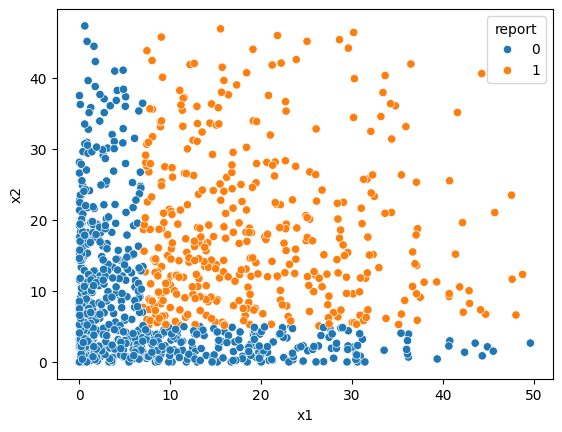

In [10]:
sns.scatterplot(data=raw_df, x='x1', y='x2', hue='report');

In [11]:
model_network = [[[20., 0, -130], [0., 20, -90]], [[20., 20, -30]]]

In [12]:
f_model_network = [[[20., 0, -100], [0., 20, -80]], [[20., 20, -30]]]

In [13]:
mdlpd = []
for i in range(len(x1)):
    mdlpd.append(feed_forward(model_network, [x1[i],x2[i]])[1][0])
np.round(Cost(mdlpd, y))

0.0

In [14]:
mdlpd = []
for i in range(len(x1)):
    mdlpd.append(feed_forward(f_model_network, [x1[i],x2[i]])[1][0])
np.round(Cost(mdlpd, y), 3)

0.081

# Backpropagation

Backpropagation is called because of what happens when we are using gradientDescend to optimize the NN, we are going kind of backwards.\
This is because we are optimizing the NN with the **CHAIN RULE**

## XOR training

In [15]:
def sqerror_gradients(network: List[List[Vector]], input_vector: Vector, target_vector: Vector) -> List[List[Vector]]:
    # forward pass
    hidden_outputs, outputs = feed_forward(network, input_vector)
    # gradients with respect to output neuron pre-activation outputs
    output_deltas = [output * (1 - output) * (output - target) for output, target in zip(outputs, target_vector)]
    # gradients with respect to output neuron weights
    output_grads = [[output_deltas[i] * hidden_output for hidden_output in hidden_outputs + [1]] for i, output_neuron in enumerate(network[-1])]
    # gradients with respect to hidden neuron pre-activation outputs
    hidden_deltas = [hidden_output * (1 - hidden_output) * dot(output_deltas, [n[i] for n in network[-1]]) for i, hidden_output in enumerate(hidden_outputs)]
    # gradients with respect to hidden neuron weights
    hidden_grads = [[hidden_deltas[i] * input for input in input_vector + [1]] for i, hidden_neuron in enumerate(network[0])]
    return [hidden_grads, output_grads]

In [16]:
import random
random.seed(0)
# training data
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]
# start with random weights
network = [ # hidden layer: 2 inputs -> 2 outputs
    [[random.random() for _ in range(2 + 1)], # 1st hidden neuron
    [random.random() for _ in range(2 + 1)]], # 2nd hidden neuron
    # output layer: 2 inputs -> 1 output
    [[random.random() for _ in range(2 + 1)]] # 1st output neuron
    ]

In [17]:
import tqdm
from gradient_descent import gradient_step
learning_rate = 1.0
for epoch in tqdm.trange(20000, desc="neural net for xor"):
    for x, y in zip(xs, ys):
        gradients = sqerror_gradients(network, x, y)
        # Take a gradient step for each neuron in each layer
        network = [[gradient_step(neuron, grad, -learning_rate) for neuron, grad in zip(layer, layer_grad)] for layer, layer_grad in zip(network, gradients)]
# check that it learned XOR
assert feed_forward(network, [0, 0])[-1][0] < 0.01
assert feed_forward(network, [0, 1])[-1][0] > 0.99
assert feed_forward(network, [1, 0])[-1][0] > 0.99
assert feed_forward(network, [1, 1])[-1][0] < 0.01

neural net for xor: 100%|██████████████████████████████████████████████████████| 20000/20000 [00:02<00:00, 8656.71it/s]


In [18]:
network

[[[6.953505610104289, 6.952785792366962, -3.1484761965046655],
  [5.115899442661922, 5.115407875835949, -7.839603434415663]],
 [[10.961705832630562, -11.63060534664317, -5.144229056613082]]]

## Xpert Train

In [33]:
inputs_df = raw_df
xs = inputs_df[["x1","x2","ones"]].to_numpy()
ys = inputs_df[["report"]].to_numpy()

test_df = pd.read_csv('sevenfiveVALIDATION.csv')
test_df["ones"] = 1
ts = test_df[["x1","x2","ones"]].to_numpy()
tys =  test_df[["report"]].to_numpy()
NUM_HIDDEN = 25
network = [
    [[random.random() for _ in range(2 + 1)] for _ in range(NUM_HIDDEN)],
    [[random.random() for _ in range(NUM_HIDDEN + 1)] for _ in range(1)]
]

In [34]:
network

[[[0.7342793416571158, 0.03070084595190614, 0.4467185991338365],
  [0.6864181042985581, 0.030134234552269934, 0.9192823534016137],
  [0.9622424865104192, 0.72254277208884, 0.0785385396518038],
  [0.07032946587635569, 0.3592533148212369, 0.029377507756986443],
  [0.3478777272843395, 0.009964241312966027, 0.9743235128409679],
  [0.8190066990688627, 0.07051761147818736, 0.8934350918478603],
  [0.20797804000401565, 0.20479079826934998, 0.6737591455288341],
  [0.9382622681625481, 0.12318812122923739, 0.007184567252270457],
  [0.3691301471700257, 0.024650014436155776, 0.6048482375805311],
  [0.8591756086192088, 0.1869917024228578, 0.11239103583018406],
  [0.34444960733861085, 0.9591715206073138, 0.13015769442868408],
  [0.9665192604669938, 0.36223986994484925, 0.47337040276011155],
  [0.29263198596497353, 0.9371268442154698, 0.9581478949874975],
  [0.6359157065077434, 0.18404555017515556, 0.9929517886102871],
  [0.10258043954691198, 0.5808493815940804, 0.15640306008300875],
  [0.897675314150

In [35]:
from linear_algebra import squared_distance
learning_rate = 0.15
with tqdm.trange(500) as t:
    for epoch in t:
        epoch_loss = 0.0
        for x, y in zip(xs, ys):
            predicted = feed_forward(network, x)[-1]
            epoch_loss += squared_distance(predicted, y)
            gradients = sqerror_gradients(network, x, y)
            # Take a gradient step for each neuron in each layer
            network = [[gradient_step(neuron, grad, -learning_rate) for neuron, grad in zip(layer, layer_grad)] for layer, layer_grad in zip(network, gradients)]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:24<00:00,  2.45it/s]


In [36]:
mdlpd = []
for i in range(len(xs)):
    mdlpd.append(feed_forward(network, xs[i,:])[1][0])
print(Cost(mdlpd, ys))
mdlpd = []
for i in range(len(ts)):
    mdlpd.append(feed_forward(network, ts[i,:])[1][0])
print(Cost(mdlpd, tys))

0.018001075317657673
0.019839536228894884


In [37]:
"""
[[[20., 0, -130], 
[0., 20, -90]], 
[[20., 20, -30]]]
"""
network

[[[0.8218518881037118, 0.253850663220102, 0.4947576139301248],
  [4.4090876124284595, -0.1700140061682282, -18.342887291824827],
  [0.9571944686729941, 0.7159854980752874, 0.07035323490422021],
  [0.49732054233514306, 0.6212184727452082, 0.18463767967349587],
  [1.3596538015618338, -0.25977472462434464, -5.555407945832511],
  [0.8611715834379552, 0.19661040696816515, 0.9123614728447681],
  [-0.5000205300711437, 7.118984748910465, -19.77361463507823],
  [1.019549947708604, 0.319231757070219, 0.07499827207456643],
  [3.1350178748356052, 0.3926335228663476, -13.904140194922796],
  [-0.29412998619678055, -0.26430327752643623, -2.706241190921012],
  [0.4410176930526992, 1.010766207267308, 0.17479082259832393],
  [1.004277063080517, 0.42706575656124174, 0.5108994495204213],
  [0.3388174947581229, 0.9581338352129255, 0.9744889908256233],
  [0.6535603157071079, 0.21715182960821344, 0.9793354042324116],
  [0.4775070327516702, 0.7829922700446901, 0.3143647018234346],
  [0.9011226837233781, 0.949

In [38]:
print(feed_forward(network, [0, 0])[-1][0],
feed_forward(network, [5, 3])[-1][0], #Uno si Uno no
feed_forward(network, [8, 9])[-1][0], #Si Si
feed_forward(network, [9, 9])[-1][0]) #SI

4.4867180642653426e-05 0.3348304820172165 0.998747017777492 0.9988242560389965


## First Test

Create a mapping method so the output comes as a vector.

In [25]:
def fizz_buzz_encode(x: int) -> Vector:
    if x % 15 == 0:
        return [0, 0, 0, 1]
    if x % 5 == 0:
        return [0, 0, 1, 0]
    if x % 3 == 0:
        return [0, 1, 0, 0]
    else:
        return [1, 0, 0, 0]

Because we do not care the sequence of the numbers or if they have a relationship with eachother.\
Incredible or not, it is better to use the numbers as binary codes so computer can understands what is happening instead of just giving an exact number.

In [26]:
def binary_encode(x: int) -> Vector:
    binary: List[float] = []
    for i in range(10):
        binary.append(x % 2)
        x = x // 2
        
    return binary

In [27]:
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

In [28]:
NUM_HIDDEN = 25
network = [
    # hidden layer: 10 inputs -> NUM_HIDDEN outputs
    [[random.random() for _ in range(10 + 1)] for _ in range(NUM_HIDDEN)],
    # output_layer: NUM_HIDDEN inputs -> 4 outputs
    [[random.random() for _ in range(NUM_HIDDEN + 1)] for _ in range(4)]
]


In [29]:
learning_rate = 1.0
with tqdm.trange(500) as t:
    for epoch in t:
        epoch_loss = 0.0
        for x, y in zip(xs, ys):
            predicted = feed_forward(network, x)[-1]
            epoch_loss += squared_distance(predicted, y)
            gradients = sqerror_gradients(network, x, y)
            # Take a gradient step for each neuron in each layer
            network = [[gradient_step(neuron, grad, -learning_rate) for neuron, grad in zip(layer, layer_grad)] for layer, layer_grad in zip(network, gradients)]
t.set_description(f"fizz buzz (loss: {epoch_loss:.2f})")

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:11<00:00,  1.99it/s]


In [30]:
def argmax(xs: list) -> int:
    """Returns the index of the largest value"""
    return max(range(len(xs)), key=lambda i: xs[i])

In [31]:
num_correct = 0
for n in range(1, 101):
    x = binary_encode(n)
    predicted = argmax(feed_forward(network, x)[-1])
    actual = argmax(fizz_buzz_encode(n))
    labels = [str(n), "fizz", "buzz", "fizzbuzz"]
    print(n, labels[predicted], labels[actual])
    if predicted == actual:
        num_correct += 1
print(num_correct, "/", 100)

1 1 1
2 2 2
3 fizz fizz
4 4 4
5 buzz buzz
6 fizz fizz
7 7 7
8 fizz 8
9 fizz fizz
10 buzz buzz
11 11 11
12 fizz fizz
13 buzz 13
14 14 14
15 15 fizzbuzz
16 16 16
17 17 17
18 fizz fizz
19 19 19
20 buzz buzz
21 buzz fizz
22 22 22
23 23 23
24 fizz fizz
25 buzz buzz
26 26 26
27 fizz fizz
28 buzz 28
29 29 29
30 30 fizzbuzz
31 31 31
32 32 32
33 fizz fizz
34 34 34
35 buzz buzz
36 fizz fizz
37 37 37
38 38 38
39 fizz fizz
40 buzz buzz
41 41 41
42 fizz fizz
43 43 43
44 44 44
45 45 fizzbuzz
46 46 46
47 47 47
48 fizz fizz
49 49 49
50 buzz buzz
51 fizz fizz
52 52 52
53 53 53
54 fizz fizz
55 buzz buzz
56 56 56
57 fizz fizz
58 58 58
59 59 59
60 60 fizzbuzz
61 61 61
62 62 62
63 fizz fizz
64 64 64
65 buzz buzz
66 fizz fizz
67 67 67
68 68 68
69 fizz fizz
70 buzz buzz
71 71 71
72 fizz fizz
73 73 73
74 74 74
75 75 fizzbuzz
76 76 76
77 77 77
78 fizz fizz
79 79 79
80 buzz buzz
81 fizz fizz
82 82 82
83 83 83
84 fizz fizz
85 buzz buzz
86 86 86
87 fizz fizz
88 88 88
89 89 89
90 90 fizzbuzz
91 91 91
92 92 92
93 f

In [32]:
network[1]

[[-8.352631125812964,
  -2.077895183636747,
  0.5756207884396963,
  14.008902176723918,
  4.977516983994605,
  -2.64619431354876,
  19.185517084768044,
  1.2177585240017348,
  10.090871746357776,
  -10.896077863157362,
  -3.1964342465654165,
  -7.507782660118867,
  -12.568173707323577,
  -11.402852656402578,
  -9.376326679017179,
  7.823980390687827,
  7.5302188357120965,
  7.0760533007920845,
  -9.262352941698818,
  -8.904047113515634,
  9.593652422956357,
  19.51894440203364,
  20.742384146219063,
  -12.321602546748727,
  -10.458665417912453,
  -1.1196538426155995],
 [10.87546670065117,
  5.542282502587591,
  0.042980804045101156,
  -10.249329057580601,
  -7.754757578704245,
  7.048228535552561,
  -17.315848071034424,
  -0.6177866845032216,
  1.203788007104536,
  8.735860794766703,
  7.909608366764046,
  10.790620473119471,
  5.813784777078159,
  13.049636562669622,
  1.0070386279700612,
  6.459898660812568,
  -15.487538808280474,
  7.539513988726879,
  10.375530498277419,
  10.16994